# Impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
import re
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    result['dgemm_file'] = dgemm_file[0]
    return result

simulation_dir = ['geometry/12/']
simulation_files = [os.path.join(simdir, f) for simdir in simulation_dir for f in os.listdir(simdir) if f.endswith('.zip')]

reality_dir = ['../hpl/geometry/3']
reality_files = [os.path.join(realdir, f) for realdir in reality_dir for f in os.listdir(realdir) if f.endswith('.zip')]

dfreal = pandas.concat([read_result(a) for a in reality_files])
dfreal['mode'] = 'reality'

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['mode'] = 'simulation'
df = pandas.concat([df, dfreal])

df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_file,filename,gflops,major_page_fault,matrix_size,...,start,start_timestamp,stop_timestamp,swap,sys_time,thread_per_process,time,usr_time,nb_nodes,geometry
0,147.4250,2,512,0.99,1,dgemm_512.yaml,geometry/12/nancy_2020-06-25_2627642.zip,5415.0,0.0,200000,...,NaT,NaT,NaN,0,388.49,1,984.98,864.49,240,16×15
1,157.5230,2,512,0.99,1,dgemm_512.yaml,geometry/12/nancy_2020-06-25_2627642.zip,5646.0,0.0,300000,...,NaT,NaT,NaN,0,362.91,1,3187.88,758.91,240,10×24
2,192.8590,2,512,0.99,1,dgemm_512.yaml,geometry/12/nancy_2020-06-25_2627642.zip,5699.0,0.0,300000,...,NaT,NaT,NaN,0,508.95,1,3158.28,1026.08,240,15×16
3,104.9490,2,512,1.00,1,dgemm_512.yaml,geometry/12/nancy_2020-06-25_2627642.zip,4800.0,0.0,300000,...,NaT,NaT,NaN,0,49.89,1,3750.31,419.58,240,2×120
4,69.4407,2,512,1.00,1,dgemm_512.yaml,geometry/12/nancy_2020-06-25_2627642.zip,4915.0,0.0,200000,...,NaT,NaT,NaN,0,50.08,1,1085.11,260.95,240,4×60


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes', 'start',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp', 'dgemm_file', 'platform_id',
                  'theoretical_peak', 'theoretical_smart_peak'}
colnames = set(df) - name_exceptions
df.groupby(list(colnames))[['swap']].count()

,,,,,,,,,,,,,swap
proc_q,mem_align,depth,rfact,block_size,swap,pfact,geometry,bcast,nb_nodes,process_per_node,thread_per_process,proc_p,
15,8,1,2,512,0,1,16×15,2,240,32,1,16,12
16,8,1,2,512,0,1,15×16,2,240,32,1,15,12
20,8,1,2,512,0,1,12×20,2,240,32,1,12,12
24,8,1,2,512,0,1,10×24,2,240,32,1,10,12
30,8,1,2,512,0,1,8×30,2,240,32,1,8,12
40,8,1,2,512,0,1,6×40,2,240,32,1,6,12
48,8,1,2,512,0,1,5×48,2,240,32,1,5,12
60,8,1,2,512,0,1,4×60,2,240,32,1,4,12
80,8,1,2,512,0,1,3×80,2,240,32,1,3,12


In [3]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

In [4]:
patches = set()
for filename in simulation_files:
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

C code for the dgemm model (notice that there is only one node, the others go to the `default` which is the same):

In [5]:
model = set()
for filename in simulation_files:
    cfile = zipfile.ZipFile(filename).read("dgemm_model.c").decode()
    model.add(cfile)
assert len(model) == 1
cfile = model.pop().split('\n')
line_limit = 30
if len(cfile) > line_limit:
    cfile = cfile[:line_limit]  + ['\n/* ... FILE TRUNCATED FOR THE DISPLAY ... */']
cfile = '\n'.join(cfile)
display(Markdown('```c\n%s\n```' % cfile))

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.844750e-06 + 7.652354e-11*mnk + -4.426403e-10*mn + 2.466485e-09*mk + 3.476436e-09*nk;
        sigma = 1.135036e-06 + -3.506169e-15*mnk + 1.110614e-10*mn + 9.331120e-11*mk + 9.494680e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 2.614271e-06 + 7.329908e-11*mnk + -1.046165e-10*mn + 2.403118e-09*mk + 3.548580e-09*nk;
        sigma = 5.101970e-07 + 1.882060e-14*mnk + 7.744159e-11*mn + 6.355068e-11*mk + 9.815079e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 2.541417e-06 + 7.601723e-11*mnk + -4.041720e-10*mn + 2.406434e-09*mk + 3.405428e-09*nk;
        sigma = 3.410317e-07 + 4.732979e-14*mnk + 1.059834e-10*mn + 1.313661e-10*mk + 1.209401e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.696896e-06 + 7.298058e-11*mnk + -2.751264e-10*mn + 2.378561e-09*mk + 3.350740e-09*nk;
        sigma = 6.192815e-07 + -5.777018e-14*mnk + 1.557391e-10*mn + 1.362609e-10*mk + 1.928689e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 2.525083e-06 + 7.465752e-11*mnk + -2.704652e-10*mn + 2.441854e-09*mk + 3.461994e-09*nk;
        sigma = 4.056646e-07 + 1.438745e-13*mnk + 3.477872e-11*mn + 7.246208e-11*mk + 2.530245e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 2.555771e-06 + 7.201640e-11*mnk + -2.937465e-10*mn + 2.342581e-09*mk + 3.281267e-09*nk;
        sigma = 6.264659e-07 + 6.441653e-16*mnk + 1.202864e-10*mn + 1.368940e-10*mk + 1.632467e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 2.526979e-06 + 7.194391e-11*mnk + -5.605524e-10*mn + 2.382450e-09*mk + 3.243977e-09*nk;
        sigma = 4.043562e-07 + 1.238377e-13*mnk + 1.144535e-10*mn + 1.105325e-10*mk + 4.248272e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);

/* ... FILE TRUNCATED FOR THE DISPLAY ... */
```

## HPL performance

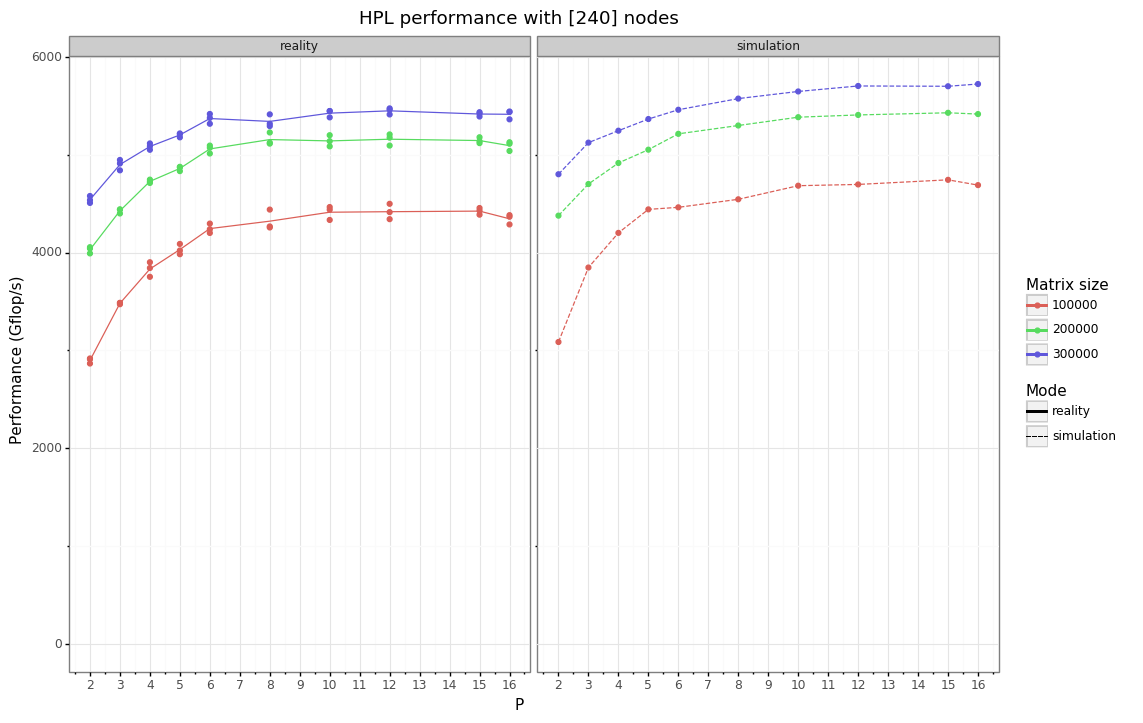

<ggplot: (-9223363274490804501)>

In [6]:
df['group'] = df['dgemm_file'].astype(str) + ':' + df['matrix_size'].astype(str) + ':' + df['mode']
(ggplot(df)
    + aes(x='proc_p', y='gflops', color='factor(matrix_size)', group='group', linetype='mode')
#    + geom_text(aes(label='geometry'), position=position_nudge(y=200))
    + stat_summary(geom='line')
    + geom_point()
    + theme_bw()
    + labs(x='P', y='Performance (Gflop/s)', color='Matrix size', linetype='Mode')
    + expand_limits(y=0)
    + scale_x_continuous(breaks=range(df['proc_p'].min(), df['proc_p'].max()+1))
    + ggtitle(f'HPL performance with {df["nb_nodes"].unique()} nodes')
    + facet_wrap('mode')
)